**환경 변수 로드**: 첫 번째 모듈의 "Getting setup"을 참조하세요. `dotenv` [문서](https://pypi.org/project/python-dotenv/)는 `../.env` 파일을 찾습니다. 파일을 찾으면 현재 셸의 변수를 덮어쓰며 환경 변수를 로드합니다. 파일을 찾지 못하면 현재 셸의 변수를 사용합니다.

In [29]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

# automatically reload all modules before executing new code. The captures changes in local packages.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ReAct 에이전트 생성 - 사전 구축된 버전

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이 과정에서는 [Deep Agent](https://blog.langchain.com/deep-agents/)를 구축할 것입니다. 코드를 크게 단순화하는 LangGraph의 '사전 구축된' 에이전트 추상화를 기반으로 구축할 것입니다. 이 수업에서는 사전 구축된 ReAct 에이전트에 대해 배울 것입니다. 학습할 내용은 다음과 같습니다:
- ReAct 에이전트란 무엇인가
- 우리 구현의 기능과 더 알아볼 수 있는 곳
	- 도구를 사용한 에이전트 구축
	- 그래프, 상태 및 메시지
	- 도구를 사용한 상태 접근 및 수정
	- <span style="font-size:0.8em;">🪝</span> 훅과 구조화된 응답


### ReAct 에이전트란 무엇인가


<img src="./assets/agent.png"
	 style="float:left; max-width:300px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1250px;">
	
LangGraph의 오픈소스 `create_react_agent` ([여기 참조](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent)) 추상화를 사용할 것입니다. **ReAct 에이전트**는 "추론과 행동"(ReAct) 프레임워크를 사용하여 사고의 연쇄(CoT) 추론과 외부 도구 사용을 결합하는 AI 에이전트입니다. 이는 [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629) 논문으로 유명해졌습니다.

이 에이전트는 세 가지 구성 요소로 이루어져 있습니다: 대형 언어 모델(LLM), 사용할 수 있는 도구 세트, 지침을 제공하는 프롬프트입니다.

LLM은 루프에서 작동합니다. 각 반복에서 사용 가능한 도구 목록을 포함한 컨텍스트를 검토하고, 도구를 호출해야 하는지 결정합니다. 호출할 도구를 선택하고 도구 호출을 형성합니다. 이것은 실행을 위해 도구 노드로 전송됩니다. 도구 노드는 도구를 실행하고 결과(관찰)를 LLM으로 다시 보냅니다. LLM은 관찰을 받고 그 관찰을 사용하여 다음 행동을 결정합니다. 에이전트가 더 이상 도구를 호출할 필요가 없다고 결정할 때까지 루프가 계속됩니다.
</div>

<div style="clear:both;"></div>

>  참고: `create_react_agent`는 곧 출시될 V1로 이동 중입니다! LangChain에 포함되며 이름이 간단히 `create_agent`로 변경됩니다.

### LangGraph 사전 구축된 `create_react_agent`의 주요 기능

`create_react_agent` 추상화와 함께 제공되는 기능들입니다. 이 과정에서 모든 기능을 사용하지는 않지만, 우리 과정을 구축하기 위해 `create_react_agent` 사용을 동기부여합니다 (더 알아보기 [여기](https://langchain-ai.github.io/langgraph/agents/overview/#what-is-an-agent)):

- [메모리 통합](../how-tos/memory/add-memory.md): _단기_(세션 기반) 및 _장기_(세션 간 지속) 메모리에 대한 네이티브 지원으로 챗봇과 어시스턴트의 상태 유지 동작을 가능하게 합니다.
- [인간 중심 루프 제어](../concepts/human_in_the_loop.md): 실행이 인간의 피드백을 기다리기 위해 _무기한_ 일시 중지될 수 있습니다—실시간 상호작용에 제한된 웹소켓 기반 솔루션과 달리. 이를 통해 워크플로우의 어느 지점에서든 비동기 승인, 수정 또는 개입이 가능합니다.
- [스트리밍 지원](../how-tos/streaming.md): 에이전트 상태, 모델 토큰, 도구 출력 또는 결합된 스트림의 실시간 스트리밍.
- [배포 도구](../tutorials/langgraph-platform/local-server.md): 인프라 없는 배포 도구를 포함합니다. [**LangGraph Platform**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)은 테스트, 디버깅 및 배포를 지원합니다.
  - [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/): 워크플로우를 검사하고 디버깅하기 위한 시각적 IDE.
  - [LangSmith](https://smith.langchain.com/): 추적 및 평가 도구.
  - 프로덕션을 위한 여러 [배포 옵션](https://langchain-ai.github.io/langgraph/concepts/deployment_options.md) 지원.

`create-react-agent`는 매우 정교하며 많은 입력 형식을 받아들이고 많은 사용자 정의를 허용합니다. 간단한 에이전트-도구 루프가 될 수 있거나, 사전/사후 훅 및/또는 구조화된 출력으로 사용자 정의할 수 있습니다.

<div style="display:flex; justify-content:center; align-items:flex-end; gap:40px;">

  <figure style="margin:0; text-align:center; width:250px;">
	<img src="./assets/simple_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
	<figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">간단한 에이전트</figcaption>
  </figure>

  <figure style="margin:0; text-align:center; width:250px;">
	<img src="./assets/complex_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
	<figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">복잡한 에이전트</figcaption>
  </figure>

</div>
</div>
<br>

이 과정에서는 간단한 형식을 사용할 것입니다—과정 후반에 하위 에이전트 <span style="font-size:20px;">🤖 🤖 🤖</span>를 추가할 것입니다!   

  

#### 도구를 사용한 에이전트 구축

시작하기 위해 간단한 계산기 도구를 사용한 에이전트를 생성해보겠습니다. 구성 방식을 확인한 후 더 자세한 내용을 살펴보겠습니다.


In [30]:
from typing import Annotated, List, Literal, Union

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


@tool
def calculator(
	operation: Literal["add","subtract","multiply","divide"],
	a: Union[int, float],
	b: Union[int, float],
) -> Union[int, float]:
	"""Define a two-input calculator tool.

	Arg:
		operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
		a (float or int): The first number.
		b (float or int): The second number.
		
	Returns:
		result (float or int): the result of the operation
	Example
		Divide: result   = a / b
		Subtract: result = a - b
	"""
	if operation == 'divide' and b == 0:
		return {"error": "Division by zero is not allowed."}

	# Perform calculation
	if operation == 'add':
		result = a + b
	elif operation == 'subtract':
		result = a - b
	elif operation == 'multiply':
		result = a * b
	elif operation == 'divide':
		result = a / b
	else: 
		result = "unknown operation"
	return result


E0000 00:00:1760676545.381043  488840 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


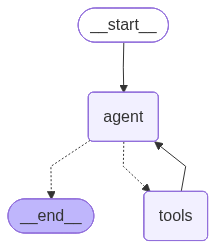

In [31]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

# Create agent using create_react_agent directly

SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)
tools = [calculator]

# Create agent
agent = create_react_agent(
	model,
	tools,
	prompt=SYSTEM_PROMPT,
	#state_schema=AgentState,  # default
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### 그래프, 상태 및 메시지
곧 에이전트를 실행할 것이지만, 그래프에 대해 조금 더 자세히 살펴보겠습니다.
세부 사항을 보고 싶다면 `create_react_agent`를 구현하는 코드를 [여기](https://github.com/langchain-ai/langgraph/blob/c37c9cbab3287f0988fabe2b853569a23960e3db/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py)에서 확인할 수 있습니다. 이것의 간단한 버전을 직접 구축해보고 싶다면 [Foundation: Introduction to LangGraph, Module 1, Lesson 6, Agent](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)를 확인해보세요.

**에이전트 정의**: 위에서 했던 것처럼 에이전트를 정의할 때 제공하는 것들: 모델, 하나 이상의 도구, "시스템" 프롬프트, 그리고 기본적으로 <a href="https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py#L62-L69">
  <code style="color:#0366d6;">AgentState</code>
</a>인 상태 스키마로 주로 메시지 목록입니다. ([호출 세부사항은 여기](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent))
내부적으로 이것은 위에 표시된 LangGraph 그래프를 정의하고 컴파일하는 것입니다. 중요한 세부사항은 도구 노드가 또 다른 사전 구축된 항목인 `ToolNode`라는 것입니다. [여기](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/tool_node.py#L239-L293)에 설명되어 있습니다. 도구 노드는 LLM의 메시지에서 식별된 모든 도구를 실행하고 결과를 반환합니다.

**에이전트 호출:** 
에이전트를 호출하고 결과를 확인해보겠습니다!

In [32]:
# Example usage
result1 = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "What is 3.1 * 4.2?",
			}
		],
	}
)

format_messages(result1["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: c5ab22bc-5816-44c3-bd44-ce532188936e                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The product of 3.1 and 4.2 is 13.02.                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**에이전트 호출:** 
시퀀스 다이어그램은 모델이 호출될 때 일어나는 일을 보는 좋은 방법입니다.

<div style="display:none">
	향후를 위해 mermaid 코드가 여기에 저장됨
```mermaid
sequenceDiagram
	participant U as User
	participant A as LLM
	participant T as Tools
	Note over A: System message<br/>"You are a helpful assistant..."
	U->>A: Initial input,<br/>"What is 3.1 * 4.2?"
	loop while tool_calls present
		A->>T: AIMessage(id="call_123", tool_calls=[...])
		T-->>A: ToolMessage(tool_call_id="call_123", content="xx")
	end
	A->>U: Return final state
```
</div> 

<img src="./assets/agent_sequence_diagram.png"
	 style="float:left; max-width:500px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1100px;">
예시에서 사용자 입력은 "What is 3.1 * 4.2?"입니다. 이것이 시스템 프롬프트와 도구 설명과 함께 LLM으로 전송됩니다.  
<br/>
<p style="margin-bottom:0; margin-top:5px;">LLM은 계산기 도구를 호출해야 한다고 결정합니다. <br/> `messages`에 `AIMessage`를 추가합니다:</p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:0;">
<code class="language-python">AIMessage(
	content="",
	tool_calls=[{"id": "call_123",
				 "name": "calculator",
				 "args": {"a": 3.1, "b": 4.2, "operation": "multiply"}}])</code></pre>   
</code></pre>
<br/>
<p style="margin-bottom:0;">도구 노드는 AIMessage를 받고 모든 도구 호출을 처리합니다. tool_call_ids를 추적합니다. `messages`에 ToolMessage로 응답합니다: </p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:10px;">
<code class="language-python">ToolMessage(
	content="13.02",		 # 도구 실행의 결과
	tool_call_id="call_123")  # AIMessage.tool_calls의 id와 일치
</code></pre>
LLM은 `messages`의 응답을 검토하고 완료되었다고 결정하며 사용자에게 `AIMessage`를 형성합니다.

</div>

<div style="clear:both;"></div>

[LangSmith의 추적](https://smith.langchain.com/public/3d2062e3-8713-4510-a797-801abe44d1f7/r)을 살펴보겠습니다. 주목할 점들:
- LLM 호출의 메타데이터에서 'calculator' 도구 설명을 볼 수 있습니다.
- 모델의 응답은 인수를 포함한 도구 호출입니다.
- LLM의 최종 호출에서 도구 노드가 제공한 일치하는 tool_call_id를 확인하세요.

#### 직접 시도해보기
잠시 시간을 내어 직접 시도해보세요. 쿼리를 실행하고 LangSmith에서 확인하여 기대와 일치하는지 확인하세요. 계산기를 확장해보세요—예를 들어 제곱 함수를 추가해보세요.

In [33]:
# Try your own 
result = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "What is ...?",
			}
		],
	}
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is ...?                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Please provide the numbers and the operation you would like me to perform.                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### 도구 내에서 상태 접근 및 수정
#### 상태
LangGraph의 좋은 기능 중 하나는 상태입니다. 그래프는 각 노드가 그래프 지속 시간 동안 사용할 수 있고 장기 저장소에 지속될 수 있는 타입이 지정된 데이터 구조를 가집니다. 이를 사용하여 노드 간에 공유할 정보를 저장하고, 그래프를 디버깅하며, 장기 실행 그래프를 이전 시간으로 재설정할 수 있습니다.

그래프에 대한 상태를 정의할 때 데이터 타입과 '리듀서' 함수를 정의합니다. 리듀서는 정보가 해당 요소에 어떻게 추가되는지 설명합니다. 작업이 병렬로 실행되고 상태를 동시에 업데이트하는 여러 노드에 매핑될 때 특히 유용합니다.

이 예제에서는 기본 `AgentState`가 사용되었습니다. 이것은 [langgraph.prebuilt.chat_agent_executor](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py)에 정의되어 있습니다.   

```python
	class AgentState(TypedDict):
		"""The state of the agent."""
		messages: Annotated[Sequence[BaseMessage], add_messages]
		remaining_steps: NotRequired[RemainingSteps]
```
		
- `messages`는 LLM과 주고받는 메시지를 포함하는 [langchain_core](https://github.com/langchain-ai/langchain/blob/088095b663993b1e53cf616e1ca487d1739b0d71/libs/core/langchain_core/messages/base.py)에 정의된 `BaseMessage` 목록입니다.
	- typing.Annotated를 사용하면 타입 힌트에 임의의 메타데이터를 첨부할 수 있습니다. 구문: Annotated[Type, metadata1, metadata2, ...] 
- `add_messages` 리듀서는 새 메시지를 메시지 목록 끝에 추가합니다.  
- `remaining_steps`는 그래프의 단계를 추적합니다. 이것이 `recursion_limit`으로 초기화되는 것을 볼 수 있지만 그래프에 의해 추적되며 사용자에게는 보이지 않습니다.  
빠르게 살펴보겠습니다.

In [34]:
from IPython.display import JSON
from langchain_core.messages import messages_to_dict

JSON({"messages": messages_to_dict(result1["messages"])})

<IPython.core.display.JSON object>

#### 사용자 정의 상태
수행된 모든 연산의 목록을 유지하도록 계산기를 확장해보겠습니다. 이를 위해 상태에 목록을 추가하고 상태를 목록에 추가하는 리듀서 함수가 필요합니다. 목록이나 연산이 비어 있는 경우를 안전하게 처리합니다.

In [35]:
from langgraph.prebuilt.chat_agent_executor import AgentState


def reduce_list(left: list | None, right: list | None) -> list:
	"""Safely combine two lists, handling cases where either or both inputs might be None.

	Args:
		left (list | None): The first list to combine, or None.
		right (list | None): The second list to combine, or None.

	Returns:
		list: A new list containing all elements from both input lists.
			   If an input is None, it's treated as an empty list.
	"""
	if not left:
		left = []
	if not right:
		right = []
	return left + right

class CalcState(AgentState):
	"""Graph State."""
	ops: Annotated[List[str], reduce_list]


#### 상태 접근 
이제 업데이트를 포함하도록 계산기를 확장할 수 있습니다. 이것이 문제를 강조합니다! 이제 상태가 우리 계산기 도구의 인수입니다. 
<img src="./assets/state_arg_diagram.png" width="800" style="display:block; margin-left:0;">
다이어그램에서 명확한 것은 LLM이 도구 호출을 생성하는 임무를 맡고 있지만 컨텍스트에 그것이 없기 때문에 `state` 인수를 형성할 수 없다는 것입니다!  
해결책은 LLM 이후에 **상태를 주입**하는 것입니다.
<img src="./assets/inject_state_diagram.png" width="1000" style="display:block; margin-left:0;"> 

<div style="margin:0; padding:0">
  <p style="margin:0;">이것은 아래에 표시된 <code>InjectedState</code> 어노테이션으로 달성됩니다.</p>
  <pre style="font-size:0.90em; margin:0; padding-top:0;">
<code class="language-python">	@tool
	def calculator_wstate(
		operation: Literal["add","subtract","multiply","divide"],
		a: Union[int, float],
		b: Union[int, float],
		<span style="background:#fff3a3; padding:0 2px;">state: Annotated[CalcState, InjectedState],</span>  # ← LLM에 전송되지 않음
		<span style="background:#fff3a3; padding:0 2px;">tool_call_id: Annotated[str, InjectedToolCallId],</span>  # ← LLM에 전송되지 않음
	) -> Union[int, float]:
</code></pre>
<p style="margin:0; padding-top:4px;">
	이것은 LLM에 제공된 설명에서 <code>state</code>를 제거하고 <code>ToolNode</code>에서 도구를 호출할 때 주입합니다. <code>tool_call_id</code>도 포함됩니다. 이것은 다음 섹션에서 설명됩니다.
  </p>
</div>

#### 상태 업데이트
도구는 일반적으로 상태의 `messages` 필드에 포함된 `ToolMessage`에서 LLM에 관찰을 반환한다는 것을 기억할 수 있습니다. 상태의 추가 멤버를 업데이트하기 위해 이 업데이트를 확장하고 싶습니다. 아래 반환에서처럼 `Command`를 사용하여 수행됩니다. 
```python
	return Command(
		update={
			"ops": ops,
			"messages": [
				ToolMessage(f"{result}", tool_call_id=tool_call_id)
			]})
```
`ToolMessage`를 생성하려면 `tool_call_id`가 필요하다는 점에 유의하세요.

In [36]:
@tool
def calculator_wstate(
	operation: Literal["add","subtract","multiply","divide"],
	a: Union[int, float],
	b: Union[int, float],
	state: Annotated[CalcState, InjectedState],   # not sent to LLM
	tool_call_id: Annotated[str, InjectedToolCallId] # not sent to LLM
) -> Union[int, float]:
	"""Define a two-input calculator tool.

	Arg:
		operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
		a (float or int): The first number.
		b (float or int): The second number.
		
	Returns:
		result (float or int): the result of the operation
	Example
		Divide: result   = a / b
		Subtract: result = a - b
	"""
	if operation == 'divide' and b == 0:
		return {"error": "Division by zero is not allowed."}

	# Perform calculation
	if operation == 'add':
		result = a + b
	elif operation == 'subtract':
		result = a - b
	elif operation == 'multiply':
		result = a * b
	elif operation == 'divide':
		result = a / b
	else: 
		result = "unknown operation"
	ops = [f"({operation}, {a}, {b})," ]
	return Command(
		update={
			"ops": ops,
			"messages": [
				ToolMessage(f"{result}", tool_call_id=tool_call_id)
			],
		}
	)



In [37]:
SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)
tools = [calculator_wstate]  # new tool

# Create agent
agent = create_react_agent(
	model,
	tools,
	prompt=SYSTEM_PROMPT,
	state_schema=CalcState,  # now defining state scheme
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

E0000 00:00:1760676549.755835  488840 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [38]:
# Example usage
result2 = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "What is 3.1 * 4.2?",
			}
		],
	}
)

format_messages(result2["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: cfc21ea7-0992-4b7f-8ff4-4cd93c195d06                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [39]:
# notice the ops field is now in the response
JSON(result2)

<IPython.core.display.JSON object>

한 가지 더 시도해보겠습니다. 이 예제에서 이중 도구 호출에 주의하세요. 도구 노드는 이들을 병렬로 실행합니다.

In [40]:
# Example usage
result3 = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "What is 3.1 * 4.2 + 5.5 * 6.5?",
			}
		],
	}
)

format_messages(result3["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2 + 5.5 * 6.5?                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: 693e021f-4f83-48c4-a782-220c197ad0fe                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 5.5,                                                                                                     │
│   "b": 6.5                                                                                                      │
│ }                                                                                                               │
│    ID: 0b29d3d3-57b9-4bbd-86d2-6bbfcbfa41d9                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 35.75                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "a": 13.02,                                                                                                   │
│   "b": 35.75                                                                                                    │
│ }                                                                                                               │
│    ID: 22e56386-45af-4f67-980d-dfede66ba66b                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 48.769999999999996                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The result is 48.77.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [41]:
JSON(result3)

<IPython.core.display.JSON object>

In [42]:
# Example usage - create your own
result4 = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "Create an example of your own?",
			}
		],
	}
)

format_messages(result4["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Create an example of your own?                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "a": 5,                                                                                                       │
│   "b": 3                                                                                                        │
│ }                                                                                                               │
│    ID: ecbde64f-b25e-4edc-8dc7-7342a8aeaaa9                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 8                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I added 5 and 3 to get 8.                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## <span style="font-size:0.8em;">🪝</span> 훅과 구조화된 응답

<table>
<tr>
<td style="width:300px;">
  <img src="./assets/complex_agent.png" style="max-width:100%; height:auto;">
</td>
<td>
  <code>create_react_agent</code>는 많은 추가 기능이 있습니다.  
  이 과정에서는 이들을 사용하지 않을 것이므로 여기서 설명만 하고 탐색은 다른 과정으로 남겨두겠습니다. 

  - 참고로 `create_react_agent` 호출 정의는 [여기](https://langchain-ai.github.io/langgraph/reference/agents/#:~:text=of%20the%20agent.-,create_react_agent,-%C2%B6)에 있습니다.

  - 사전 훅(pre-hook): 에이전트 노드 이전에 노드를 삽입합니다. `state`에 접근할 수 있습니다. 이는 메시지를 요약하거나 압축하여 관리하는 데 자주 사용됩니다. 자세한 내용은 [여기](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-manage-message-history/#keep-the-original-message-history-unmodified:~:text=to%20the%20LLM.-,def%20pre_model_hook(state)%3A,-trimmed_messages%20%3D%20trim_messages)를 참조하세요.
  - 사후 훅(post-hook): LLM 호출 이후, 도구 호출 이전에 노드를 삽입합니다. 이는 인간의 개입, 가드레일, 검증 또는 기타 후처리를 구현하는 데 유용합니다.
  - response_format: `END` 이전에 노드를 추가합니다. 이는 LLM.with_structured_output을 호출하고 출력은 주어진 스키마와 일치하도록 형식화되어 'structured_response' 상태 키에 반환됩니다.
</td>
</tr>
</table> 

 